<a href="https://colab.research.google.com/github/mopala/ML-DL/blob/main/Mnist/KNN_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import scipy.stats as sstats
import seaborn as sns
from sklearn import datasets
import tensorflow as tf

In [33]:
mnist=tf.keras.datasets.mnist
(X_train,y_train),(X_test,y_test)=mnist.load_data()
x_train=np.array(X_train)
x_train=x_train.reshape([-1,28,28,1])
x_train=x_train/255
x_test=np.array(X_test)
x_test=x_test/255
x_test=x_test.reshape([-1,28,28,1])

In [34]:
x_train_partial=x_train[0:50000,:,:,:]
x_val=x_train[50000:60000,:,:,:]
y_train_partial=y_train[0:50000]
y_val=y_train[50000:60000]
print(x_train_partial.shape)
print(x_val.shape)
print(y_train_partial.shape)
print(y_val.shape)
print(y_train.shape)

(50000, 28, 28, 1)
(10000, 28, 28, 1)
(50000,)
(10000,)
(60000,)


In [35]:
def err_rates(preds, test_Y):
    ret = {}
    for k, preds_k in  preds.items():
        pom= preds_k != test_Y
        ret[k] = sum(pom)/len(test_Y)
    return ret

In [36]:
def KNN(train_X, train_Y, test_X, ks):
    train_X = train_X.astype(np.float32)
    test_X = test_X.astype(np.float32)

    preds = {}
    Ntrain,_= train_X.shape
    Ntest,_=test_X.shape
    dists = np.zeros([Ntest,Ntrain])
    w1=np.sum(test_X*test_X,axis=1,keepdims=True)
    w2=np.sum(train_X.T*train_X.T,axis=0,keepdims=True)
    dists=np.matmul(test_X,train_X.T)*-2.0
    dists=dists+w1
    dists=dists+w2
    
    assert(dists.any()>=0)
    closest = np.argsort(dists)
    
    targets = train_Y[closest]
    for k in ks:
        predictions = sstats.mode(targets[:,0:k],axis=1)
        predictions=predictions[0]
        predictions = predictions.ravel()
        preds[k] = predictions
    return preds

In [37]:
def batched_KNN(train_X, train_Y, test_X, ks, verbose=False, batch_size=200):
    all_preds = {k: [] for k in ks}
    for i in tqdm(range(0, test_X.shape[0], batch_size)):
        batch_X = test_X[i:i + batch_size]
        
        res=KNN(train_X,train_Y,batch_X,ks)
        for k in all_preds.keys():
            res[k]=res[k].reshape(batch_size,1)
            if i==0:
                all_preds[k]=res[k]
            else:
                all_preds[k] = np.concatenate((all_preds[k],res[k]))
    return all_preds

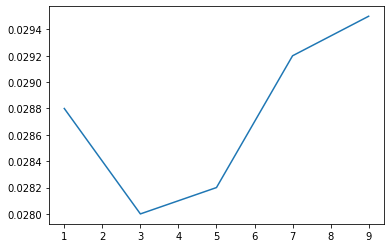

In [39]:
ks = [1, 3, 5, 7, 9]
preds = batched_KNN(
    x_train_partial.astype('float32').reshape(-1, 28*28), y_train_partial,
    x_val.astype('float32').reshape(-1, 28*28),
    ks)
mnist_validation_errs = err_rates(preds, y_val.reshape(10000,1))

plt.plot(ks, [mnist_validation_errs[k] for k in ks])

In [41]:
import timeit

start = timeit.default_timer()

best_K = 3

test_preds = batched_KNN(
    x_train.astype('float32').reshape(-1, 28*28), y_train,
    x_test.astype('float32').reshape(-1, 28*28),
    ks)
mnist_test_errs = err_rates(test_preds, y_test.reshape(10000,1))
mnist_test_errs[best_K]=mnist_test_errs[best_K].reshape(1,1)
print(f"\n\nWhen k={best_K} the test error rate is {mnist_test_errs[best_K] * 100.0}%%")
print(mnist_test_errs[best_K] * 100.0)

stop = timeit.default_timer()

print('Time: ', stop - start)  




When k=3 the test error rate is [[2.95]]%%
[[2.95]]
Time:  82.2271535320001
